In [183]:
import pickle
from IPython.core.display import display, HTML

import pandas as pd
import numpy as np
from cmocean.cm import balance_r, haline, thermal
import matplotlib.pyplot as pl
from matplotlib import rcParams
from seaborn import heatmap, PairGrid, kdeplot, distplot
import cartopy.crs as ccrs
from cartopy.io.img_tiles import StamenTerrain

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [196]:
display(HTML("<style>.container {width:95% !important}</style>"))

In [104]:
rcParams['xtick.labelsize']=16
rcParams['ytick.labelsize']=16
rcParams['font.size'] = 16
rcParams['axes.labelsize'] = 16

In [3]:
% matplotlib inline

In [4]:
with open('./Dataset/aurin_v1.pkl', 'rb') as fb:
    dataset = pickle.load(fb)

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51192 entries, 0 to 51191
Data columns (total 16 columns):
sample_id    51192 non-null int32
year         51192 non-null uint16
month        51192 non-null uint8
day          51192 non-null uint8
hr           51192 non-null uint8
min          51192 non-null uint8
lat          51192 non-null float64
lon          51192 non-null float64
bdepth       51086 non-null float64
depth        51188 non-null float64
Wt           47432 non-null float64
Sal          47542 non-null float64
ag412        48378 non-null float64
S275:295     2480 non-null float64
DOC          1957 non-null float64
POC          625 non-null float64
dtypes: float64(10), int32(1), uint16(1), uint8(4)
memory usage: 4.8 MB


In [6]:
df_novak = pd.read_pickle('./Dataset/novak_v1.pkl')

In [7]:
df_novak.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1325 entries, 1 to 1325
Data columns (total 17 columns):
sample_id    1325 non-null object
year         1325 non-null object
month        1325 non-null object
day          1325 non-null object
hr           1325 non-null object
min          1325 non-null object
lat          1325 non-null object
lon          1325 non-null object
bdepth       1224 non-null object
depth        1135 non-null object
Wt           816 non-null object
Sal          997 non-null object
ag412        1207 non-null object
S275:295     1208 non-null object
DOC          1258 non-null object
POC1         1321 non-null object
POC2         1321 non-null object
dtypes: object(17)
memory usage: 176.1+ KB


In [8]:
df_novak.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 749 entries, 1 to 1046
Data columns (total 17 columns):
sample_id    749 non-null object
year         749 non-null object
month        749 non-null object
day          749 non-null object
hr           749 non-null object
min          749 non-null object
lat          749 non-null object
lon          749 non-null object
bdepth       749 non-null object
depth        749 non-null object
Wt           749 non-null object
Sal          749 non-null object
ag412        749 non-null object
S275:295     749 non-null object
DOC          749 non-null object
POC1         749 non-null object
POC2         749 non-null object
dtypes: object(17)
memory usage: 105.3+ KB


In [9]:
df_merged = pd.read_pickle('./Dataset/novak_aurin_merged_v1.pkl')

In [10]:
df_merged.rename(columns=dict(min='mn'), inplace=True)

In [11]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52517 entries, 1 to 51191
Data columns (total 14 columns):
year        52517 non-null object
month       52517 non-null object
day         52517 non-null object
hr          52517 non-null object
mn          52517 non-null object
lat         52517 non-null object
lon         52517 non-null object
bdepth      52310 non-null object
depth       52323 non-null object
Wt          48248 non-null object
Sal         48539 non-null object
ag412       49585 non-null object
S275:295    3688 non-null object
DOC         3215 non-null object
dtypes: object(14)
memory usage: 6.0+ MB


In [12]:
df_merged.loc[:, :'mn'] = df_merged.loc[:, :'mn'].astype('str')

In [13]:
df_merged.insert(0, 'time', df_merged.hr + ':' + df_merged.mn + ':00')
df_merged.insert(0, 'date', df_merged.day + '-' + df_merged.month + '-' + df_merged.year)

In [23]:
df_merged_clean = df_merged.dropna().copy()

In [24]:
df_merged_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1146 entries, 1 to 3182
Data columns (total 16 columns):
date        1146 non-null object
time        1146 non-null object
year        1146 non-null object
month       1146 non-null object
day         1146 non-null object
hr          1146 non-null object
mn          1146 non-null object
lat         1146 non-null object
lon         1146 non-null object
bdepth      1146 non-null object
depth       1146 non-null object
Wt          1146 non-null object
Sal         1146 non-null object
ag412       1146 non-null object
S275:295    1146 non-null object
DOC         1146 non-null object
dtypes: object(16)
memory usage: 152.2+ KB


In [25]:
df_merged_clean.date=pd.to_datetime(df_merged_clean.date,
                                    format='%d-%m-%Y')

In [26]:
df_merged_clean.drop(['time', 'year', 'month', 'day', 'hr', 'mn'], 
                    axis=1, inplace=True)

In [27]:
df_merged_clean.loc[:, 'lat':] = df_merged_clean.loc[:, 'lat':].astype('f8')

In [28]:
df_merged_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1146 entries, 1 to 3182
Data columns (total 10 columns):
date        1146 non-null datetime64[ns]
lat         1146 non-null float64
lon         1146 non-null float64
bdepth      1146 non-null float64
depth       1146 non-null float64
Wt          1146 non-null float64
Sal         1146 non-null float64
ag412       1146 non-null float64
S275:295    1146 non-null float64
DOC         1146 non-null float64
dtypes: datetime64[ns](1), float64(9)
memory usage: 98.5 KB


In [223]:
df_merged_clean.loc[df_merged_clean.ag412==0]

,date,lat,lon,bdepth,depth,Wt,Sal,ag412,S275:295,DOC
642,2011-06-03,39.725452,-72.495017,82.50,33.13,7.2433,32.5373,0.0,0.0,80.722327
798,2011-06-16,42.193772,-70.457410,67.05,60.83,5.6564,31.7826,0.0,0.0,76.437244
801,2011-06-16,42.503123,-70.075820,113.76,11.23,9.5313,31.5369,0.0,0.0,82.319103
978,2012-08-18,41.561382,-68.225587,41.10,2.24,18.8118,32.5276,0.0,0.0,85.602140


In [224]:
df_merged_clean.drop(df_merged_clean[df_merged_clean.ag412==0].index, inplace=True)

In [225]:
df_merged_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1141 entries, 1 to 3182
Data columns (total 10 columns):
date        1141 non-null datetime64[ns]
lat         1141 non-null float64
lon         1141 non-null float64
bdepth      1141 non-null float64
depth       1141 non-null float64
Wt          1141 non-null float64
Sal         1141 non-null float64
ag412       1141 non-null float64
S275:295    1141 non-null float64
DOC         1141 non-null float64
dtypes: datetime64[ns](1), float64(9)
memory usage: 98.1 KB


In [226]:
df_merged_clean.to_pickle('./Dataset/df_merged_clean.pkl')

In [227]:
df_merged_clean.date.dt.month.value_counts()

6     290
8     277
11    254
5     140
2      75
7      59
3      18
1      13
4       6
9       5
10      4
Name: date, dtype: int64

In [228]:
df_ms = df_merged_clean.loc[:, 'lat':]

In [229]:
df_ms.corr()

,lat,lon,bdepth,depth,Wt,Sal,ag412,S275:295,DOC
lat,1.000000,-0.658354,-0.835745,0.078518,-0.045311,-0.154847,0.220738,-0.495238,0.188281
lon,-0.658354,1.000000,0.543955,-0.001965,-0.101767,0.161480,-0.202840,0.329999,-0.242113
bdepth,-0.835745,0.543955,1.000000,0.010734,0.064596,0.258197,-0.305263,0.563760,-0.301023
depth,0.078518,-0.001965,0.010734,1.000000,-0.273130,0.262519,-0.221909,0.052132,-0.377040
Wt,-0.045311,-0.101767,0.064596,-0.273130,1.000000,-0.172700,0.027336,0.274811,0.406183
Sal,-0.154847,0.161480,0.258197,0.262519,-0.172700,1.000000,-0.611416,0.443281,-0.666061
ag412,0.220738,-0.202840,-0.305263,-0.221909,0.027336,-0.611416,1.000000,-0.773652,0.740839
S275:295,-0.495238,0.329999,0.563760,0.052132,0.274811,0.443281,-0.773652,1.000000,-0.493801
DOC,0.188281,-0.242113,-0.301023,-0.377040,0.406183,-0.666061,0.740839,-0.493801,1.000000


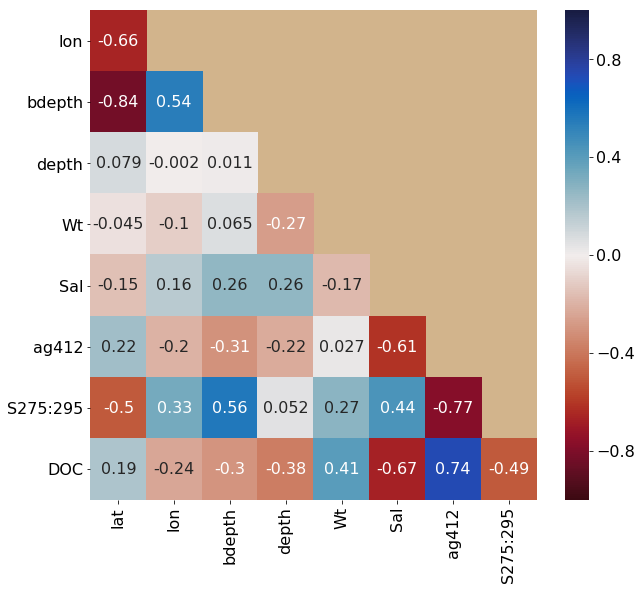

In [230]:
f, ax = pl.subplots(figsize=(10, 9))
heatmap(df_ms.corr().iloc[1:, :-1], vmin=-1, vmax=1, ax=ax,
       annot=True, cmap=balance_r, mask=np.triu(np.ones([df_ms.shape[1]-1]*2), k=1))
ax.set_facecolor('tan')
f.savefig('./FigJar/corr_heatmap.pdf', dpi=300, format='pdf')

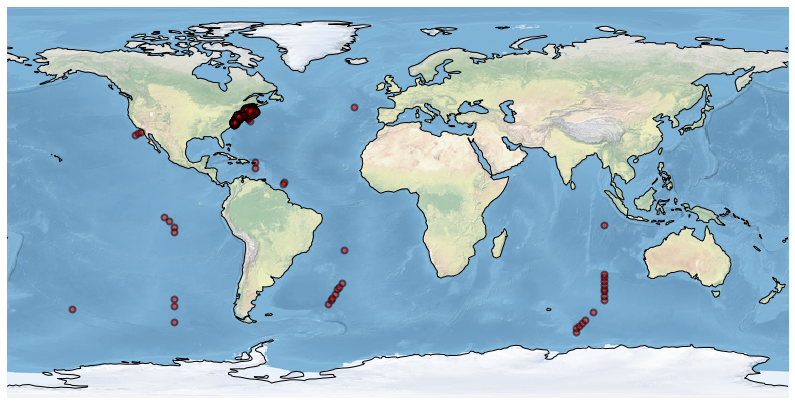

In [231]:
subplot_kw = dict(projection=ccrs.PlateCarree())
f, ax = pl.subplots(figsize=(14, 8),
                   subplot_kw=subplot_kw)
ax.background_patch.set_visible(False)
ax.outline_patch.set_visible(False)
ax.stock_img()
ax.coastlines()
ax.scatter(df_merged_clean.lon, df_merged_clean.lat,
           color='red', edgecolor='k', alpha=0.5, lw=2)
f.savefig('./FigJar/map.pdf', dpi=300, format='pdf')

In [232]:
min_lat, max_lat, min_lon, max_lon = 32, 47, -81.5, -59
df_m_c_mab = df_merged_clean.loc[((df_merged_clean.lat<=max_lat) & 
                                  (df_merged_clean.lat>=min_lat) &
                                  (df_merged_clean.lon>=min_lon) &
                                  (df_merged_clean.lon<=max_lon))]

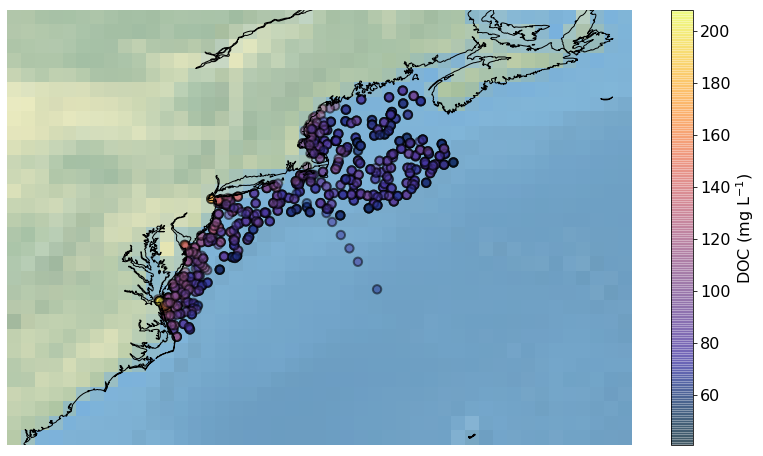

In [233]:
extent = [min_lon, max_lon, min_lat, max_lat]
subplot_kw = dict(projection=ccrs.PlateCarree())
f, ax = pl.subplots(subplot_kw=subplot_kw, figsize=(14, 8))
ax.background_patch.set_visible(False)
ax.outline_patch.set_visible(False)
ax.background_img(extent=extent)
ax.coastlines(resolution='10m')
scat = ax.scatter(df_m_c_mab.lon, df_m_c_mab.lat, cmap=thermal,
           vmin=df_m_c_mab.DOC.min(), vmax=df_m_c_mab.DOC.max(),
           c=df_m_c_mab.DOC, #c='k',
           edgecolor='k', s=70, alpha=0.5, lw=2)
cax = pl.colorbar(scat, ax=ax,)
cax.set_label(r'DOC (mg L$^{-1}$)')
ax.set_aspect('auto')
ax.set_extent(extent, crs=ccrs.PlateCarree())
f.savefig('./FigJar/mab_map.pdf', dpi=300, format='pdf')

In [234]:
df_m_c_mab.describe().T

,count,mean,std,min,25%,50%,75%,max
lat,1102.0,40.390947,2.060552,3.574517e+01,39.016300,40.639550,42.060422,44.233183
lon,1102.0,-71.078923,3.079481,-7.606900e+01,-73.900305,-70.596829,-68.364276,-65.436767
bdepth,1102.0,119.874269,270.782768,2.000000e+00,31.333334,67.900000,139.000000,4750.000000
depth,1102.0,19.815204,46.343497,0.000000e+00,2.030000,3.000000,20.640000,551.130000
Wt,1102.0,13.838871,5.554851,1.000000e-10,10.166250,13.100950,16.508450,28.357000
Sal,1102.0,31.905078,2.425384,4.980300e-01,31.441000,32.259350,32.764000,36.724800
ag412,1102.0,0.163502,0.095469,2.390129e-02,0.109210,0.140941,0.189135,0.873652
S275:295,1102.0,0.025656,0.002963,1.611367e-02,0.023894,0.025542,0.027129,0.041245
DOC,1102.0,88.751203,20.135229,4.062918e+01,75.998500,84.700538,97.798686,207.950000


In [235]:
df_m_c_mab.insert(1, 'month', df_m_c_mab.date.dt.month)

/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


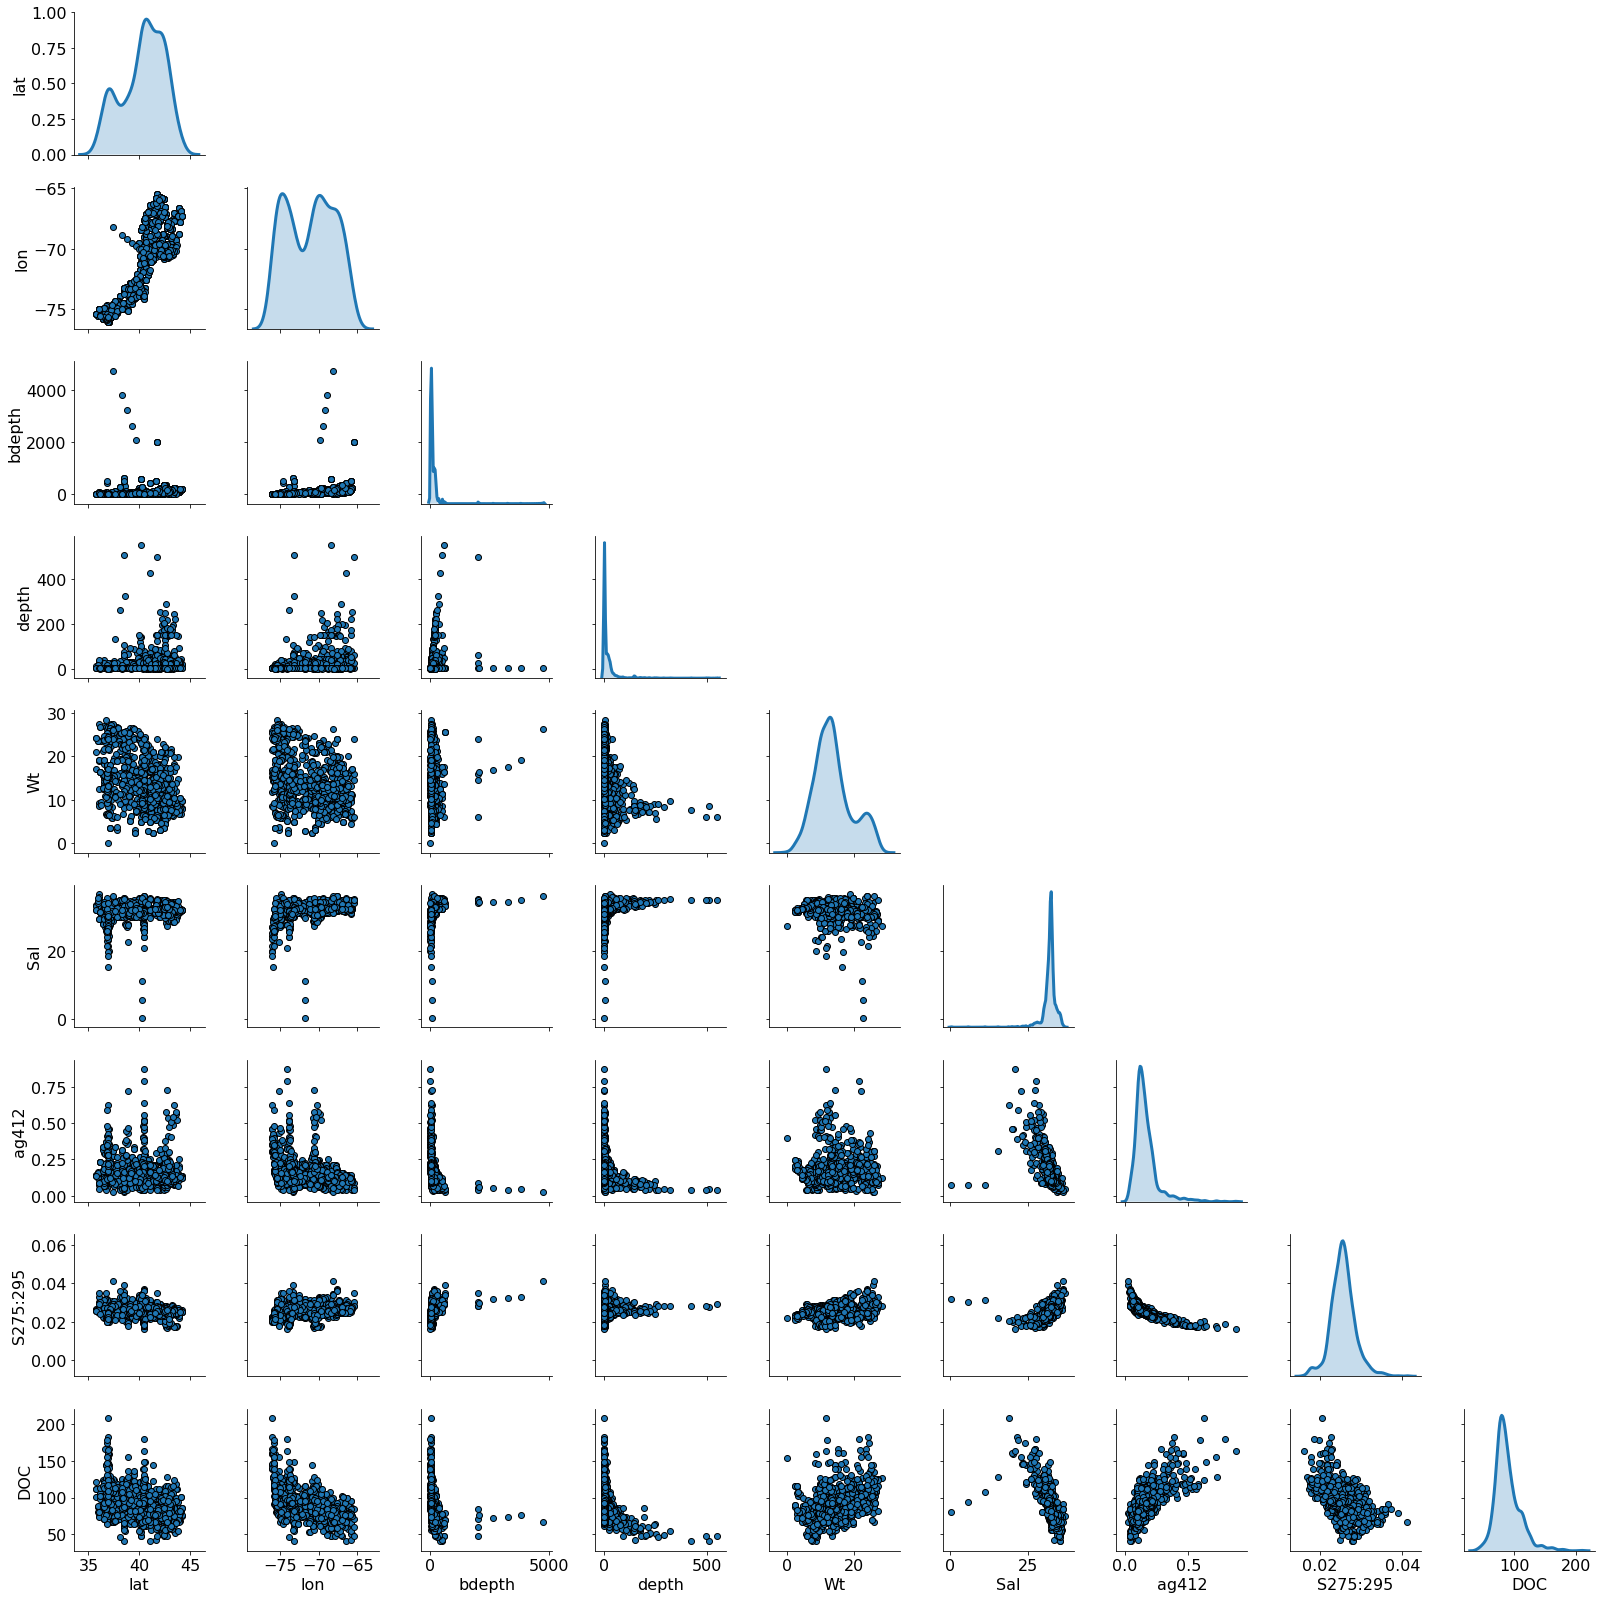

In [237]:
g = PairGrid(df_m_c_mab.loc[:,'lat':], diag_sharey=False)
g.map_diag(kdeplot, lw=3, shade=True)
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)
g.map_lower(pl.scatter, edgecolor='k')

### Transformation:

* log-transform depth bdepth, 
* standardize the rest

In [238]:
df_m_c_mab.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1102 entries, 1 to 3182
Data columns (total 11 columns):
date        1102 non-null datetime64[ns]
month       1102 non-null int64
lat         1102 non-null float64
lon         1102 non-null float64
bdepth      1102 non-null float64
depth       1102 non-null float64
Wt          1102 non-null float64
Sal         1102 non-null float64
ag412       1102 non-null float64
S275:295    1102 non-null float64
DOC         1102 non-null float64
dtypes: datetime64[ns](1), float64(9), int64(1)
memory usage: 143.3 KB


In [239]:
df_m_c_mab2 = df_m_c_mab.copy()

In [240]:
df_m_c_mab2.depth = np.log10(df_m_c_mab2.depth+1e-6)

In [241]:
df_m_c_mab2.bdepth = np.log10(df_m_c_mab2.bdepth+1e-6)

In [242]:
df_m_c_mab2.rename(columns=dict(depth='log_dep', bdepth='lob_bat_dep'), inplace=True)

In [243]:
df_m_c_mab2.head().T

,1,2,3,4,5
date,2009-08-17 00:00:00,2009-08-17 00:00:00,2009-08-17 00:00:00,2009-08-17 00:00:00,2009-08-18 00:00:00
month,8,8,8,8,8
lat,41.314,41.314,41.314,41.314,40.304
lon,-70.9444,-70.9444,-70.9444,-70.9444,-71.8109
lob_bat_dep,1.53148,1.53148,1.53148,1.53148,1.86332
log_dep,0.155336,0.646404,1.1313,1.45682,0.0899055
Wt,21.0591,20.9185,18.9376,13.9983,22.7161
Sal,31.3975,31.396,31.4249,32.1005,0.49803
ag412,0.17225,0.184552,0.200528,0.182454,0.0745892
S275:295,0.0250035,0.0241851,0.0234506,0.0236282,0.0318233


In [ ]:
df_m_c_mab2

In [244]:
x_train, x_test, y_train, y_test = train_test_split(df_m_c_mab2.loc[:, :'S275:295'],
                                                    df_m_c_mab2[['DOC']],
                                                   test_size=0.1, random_state=42)

In [245]:
x_train.head().T

,333,239,780,325,960
date,2010-05-26 00:00:00,2009-11-18 00:00:00,2011-06-15 00:00:00,2010-02-17 00:00:00,2012-08-17 00:00:00
month,5,11,6,2,8
lat,41.0959,42.2278,42.6098,42.1752,41.5173
lon,-70.5728,-67.3128,-68.9532,-70.1045,-66.2013
lob_bat_dep,1.63347,2.3483,2.31526,1.72428,1.97589
log_dep,0.285558,0.62634,1.21299,0.665581,1.59373
Wt,13.29,12.812,11.0221,4.6,9.4984
Sal,31.785,32.5092,31.8853,32.59,32.9212
ag412,0.161987,0.145687,0.105192,0.143969,0.139839
S275:295,0.0254296,0.0256213,0.0273452,0.0246741,0.0246893


In [215]:
xtrain.drop(x_train.loc[x_train.ag412==0]
x_train.drop(x

,date,month,lat,lon,lob_bat_dep,log_dep,Wt,Sal,ag412,S275:295
801,2011-06-16,6,42.503123,-70.075820,2.055990,1.050380,9.5313,31.5369,0.0,0.0
978,2012-08-18,8,41.561382,-68.225587,1.613842,0.350248,18.8118,32.5276,0.0,0.0
642,2011-06-03,6,39.725452,-72.495017,1.916454,1.520221,7.2433,32.5373,0.0,0.0
798,2011-06-16,6,42.193772,-70.457410,1.826399,1.784118,5.6564,31.7826,0.0,0.0


In [246]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((991, 10), (111, 10), (991, 1), (111, 1))

#### Stash test set

In [247]:
with open('./PickleJar/mab_test_dict.pkl', 'wb') as ftest:
    ftest_dict = dict(x_test=x_test, y_test=y_test)
    pickle.dump(ftest_dict, ftest, protocol=pickle.HIGHEST_PROTOCOL)

In [248]:
cols_to_standardize=['lat', 'lon', 'Wt', 'Sal', 'ag412', 'S275:295']
sc=StandardScaler()
sc.fit(x_train[cols_to_standardize])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [249]:
x_train_s = x_train.copy()

In [250]:
x_train_s[cols_to_standardize] = sc.fit_transform(x_train[cols_to_standardize])

In [251]:
x_train_s.describe().T

,count,mean,std,min,25%,50%,75%,max
month,991.0,7.313824e+00,2.522505,2.000000,6.000000,7.000000,8.000000,11.000000
lat,991.0,-1.429510e-15,1.000505,-2.268921,-0.672932,0.118103,0.812299,1.872391
lon,991.0,2.407173e-15,1.000505,-1.617447,-0.912943,0.155745,0.881932,1.831412
lob_bat_dep,991.0,1.825134e+00,0.429198,0.301030,1.496007,1.832509,2.143015,3.676694
log_dep,991.0,6.696695e-01,1.155061,-6.000000,0.307496,0.477121,1.316599,2.741254
Wt,991.0,-6.849269e-17,1.000505,-2.482582,-0.674637,-0.137080,0.489204,2.446664
Sal,991.0,-1.078966e-15,1.000505,-12.636285,-0.192621,0.141533,0.351998,1.937902
ag412,991.0,1.055328e-16,1.000505,-1.453675,-0.565987,-0.244933,0.274594,7.355599
S275:295,991.0,9.589817e-17,1.000505,-3.204406,-0.588813,-0.034461,0.490144,5.256064


In [252]:
x_train_s.head().T

,333,239,780,325,960
date,2010-05-26 00:00:00,2009-11-18 00:00:00,2011-06-15 00:00:00,2010-02-17 00:00:00,2012-08-17 00:00:00
month,5,11,6,2,8
lat,0.341724,0.893987,1.08033,0.868283,0.547323
lon,0.165392,1.22285,0.69077,0.317304,1.58342
lob_bat_dep,1.63347,2.3483,2.31526,1.72428,1.97589
log_dep,0.285558,0.62634,1.21299,0.665581,1.59373
Wt,-0.0932873,-0.179219,-0.501013,-1.65559,-0.774946
Sal,-0.0494011,0.241948,-0.00904999,0.274454,0.407697
ag412,-0.022156,-0.191134,-0.610942,-0.208944,-0.251759
S275:295,-0.0681498,-0.00361242,0.576734,-0.322486,-0.317367


#### Pickle original and standardized training sets, along with parameterized standardscaler and list of column labels to standardize

In [253]:
with open('./PickleJar/mab_train_dict.pkl', 'wb') as f_train:
    f_train_dict = dict(original_x = x_train,
                       stdized_x = x_train_s,
                       y=y_train, scaler=sc, col_label_list=cols_to_standardize)
    pickle.dump(f_train_dict, f_train, protocol=pickle.HIGHEST_PROTOCOL)

In [254]:
x_train_s.insert(1, 'month_name', x_train_s.date.dt.month_name())

In [255]:
x_train_s.insert(1, 'year', x_train_s.date.dt.year)
x_train_s.month_name.value_counts()

June         252
August       248
November     229
May          131
February      61
July          53
March          8
September      5
April          4
Name: month_name, dtype: int64

In [256]:
x_train_s.year.value_counts()

2010    318
2009    220
2011    147
2012    139
2006     60
2007     55
2005     45
2003      5
2008      2
Name: year, dtype: int64

In [257]:
months_ = [month for month in x_train_s.month_name.unique()]
years_ = [year for year in x_train_s.year.unique()]

In [258]:
months_, years_

(['May',
  'November',
  'June',
  'February',
  'August',
  'July',
  'April',
  'March',
  'September'],
 [2010, 2009, 2011, 2012, 2006, 2007, 2005, 2003, 2008])

/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83

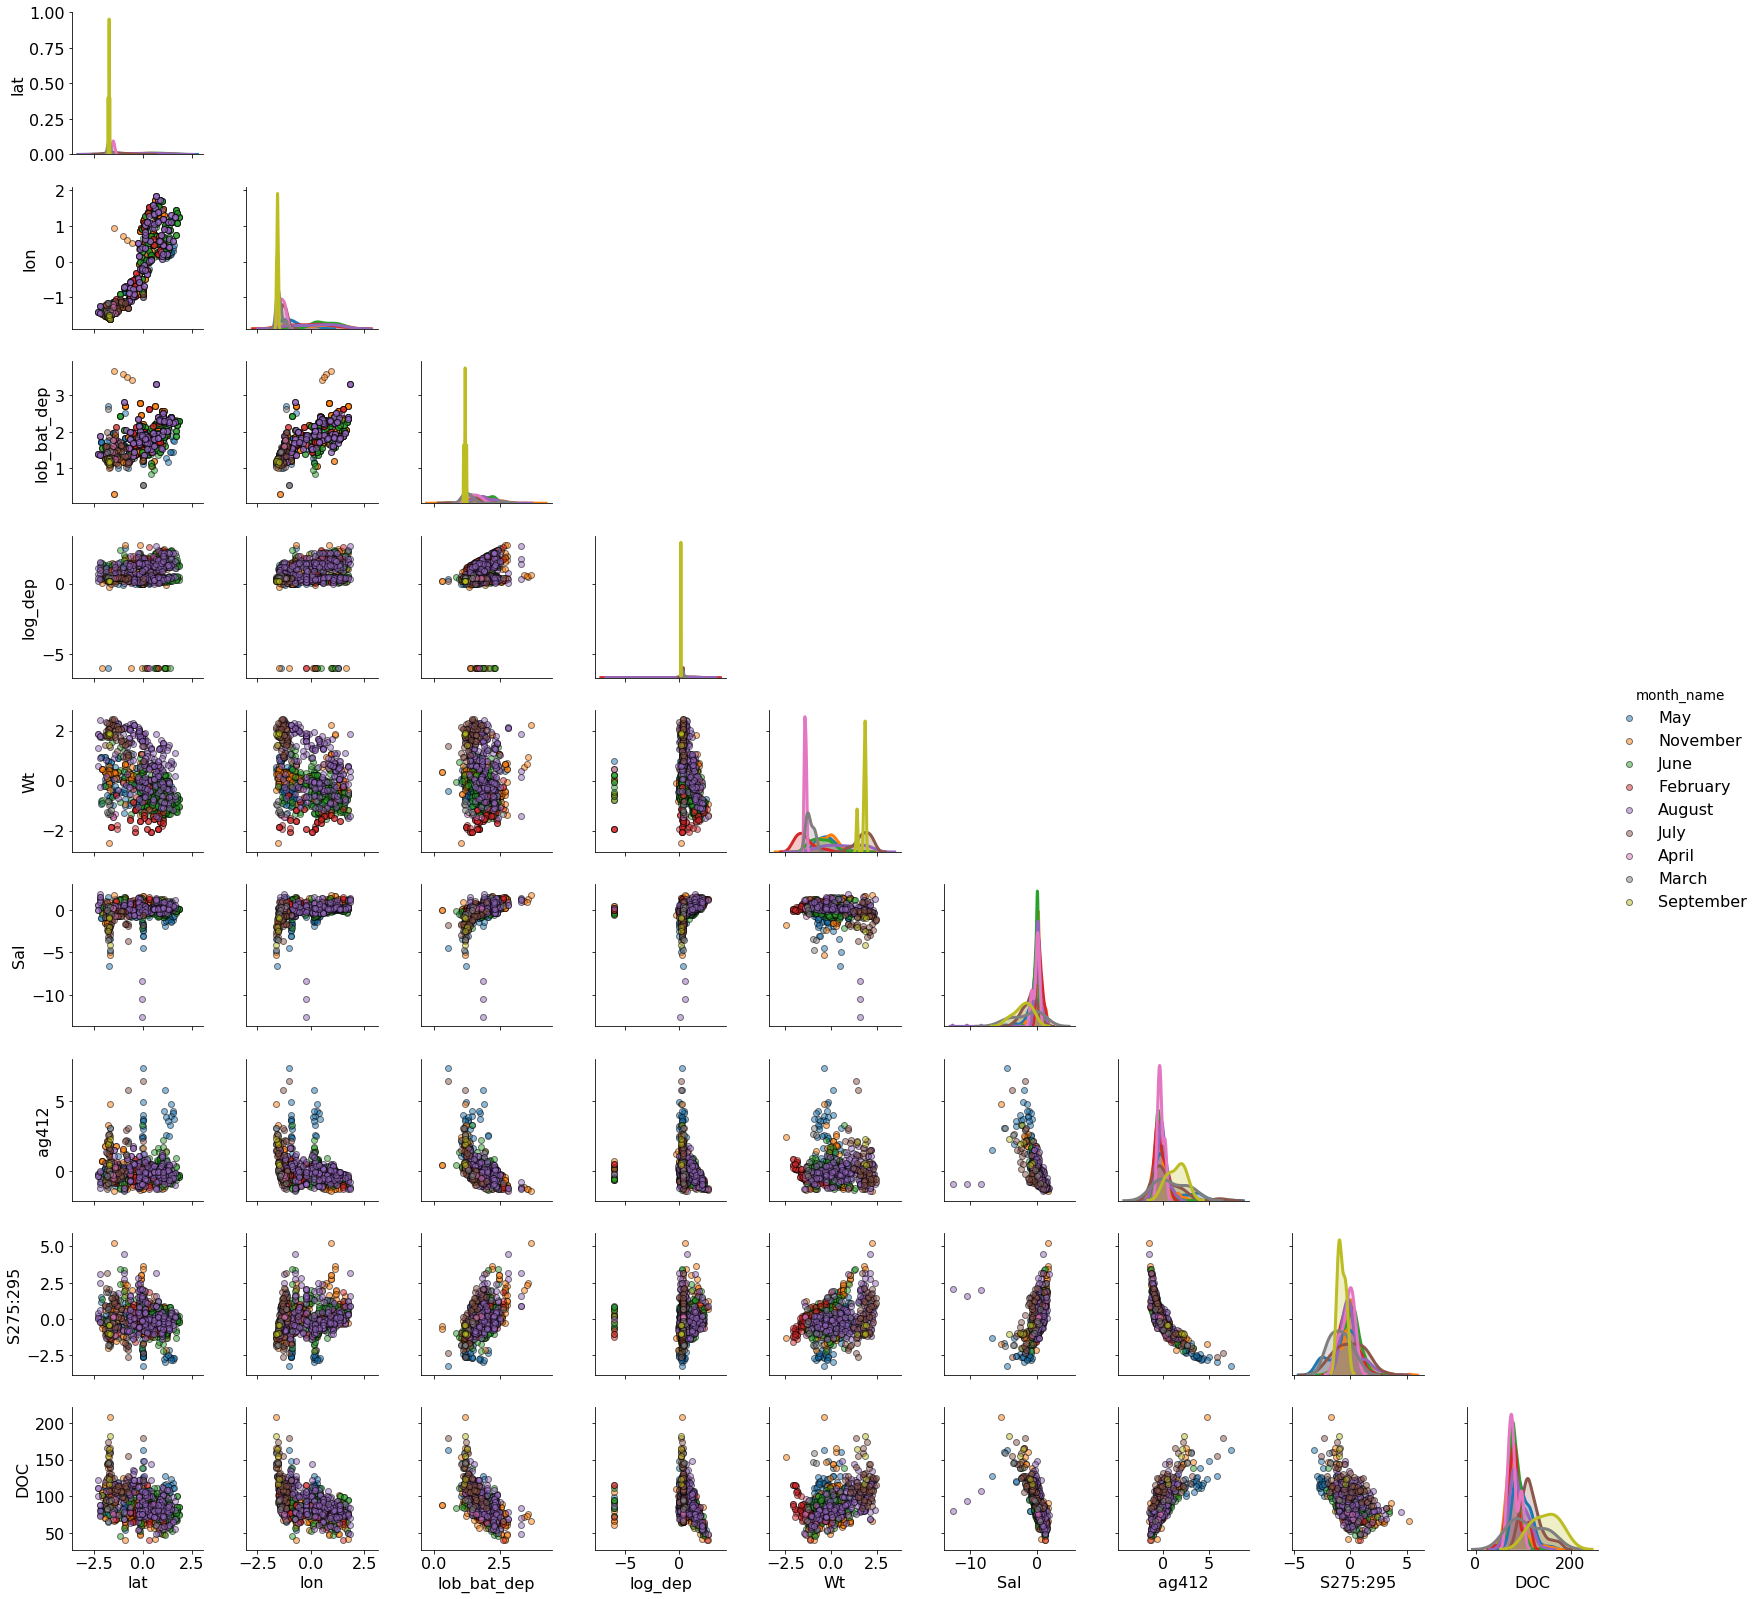

In [259]:
g = PairGrid(pd.concat((x_train_s, y_train), axis=1, ), diag_sharey=False, hue='month_name',
             vars=['lat', 'lon', 'lob_bat_dep', 'log_dep', 'Wt', 'Sal',
                  'ag412', 'S275:295', 'DOC'])
g.map_diag(kdeplot, lw=3, shade=True)
g.map_lower(pl.scatter, edgecolor='k', alpha=0.5)
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)
g.add_legend()

/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


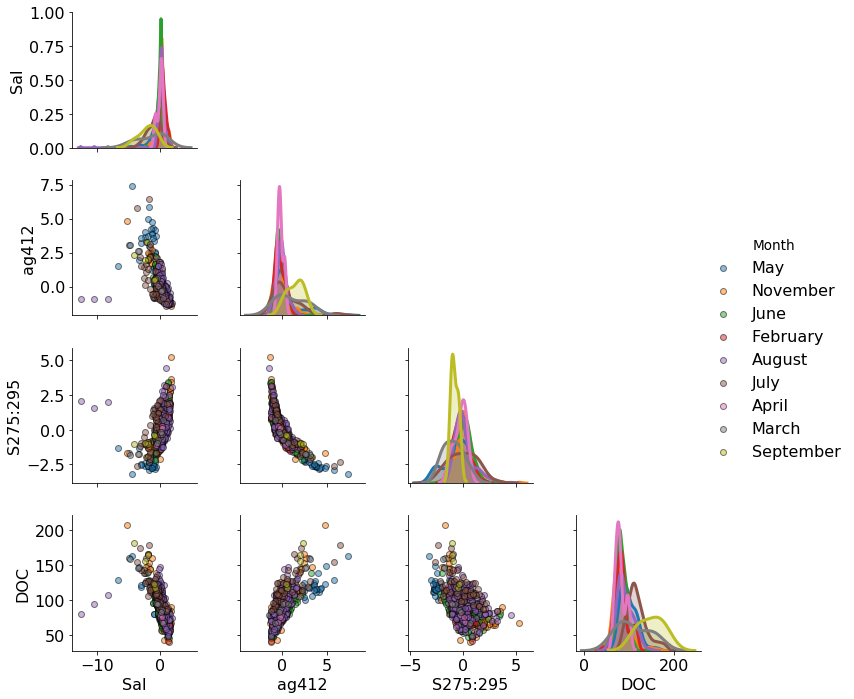

In [260]:
g = PairGrid(pd.concat((x_train_s, y_train), axis=1, ), diag_sharey=False, hue='month_name',
             vars=[ 'Sal', 'ag412', 'S275:295', 'DOC'])
g.map_diag(kdeplot, lw=3, shade=True)
g.map_lower(pl.scatter, edgecolor='k', alpha=0.5)
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)
g.add_legend(title='Month');

/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


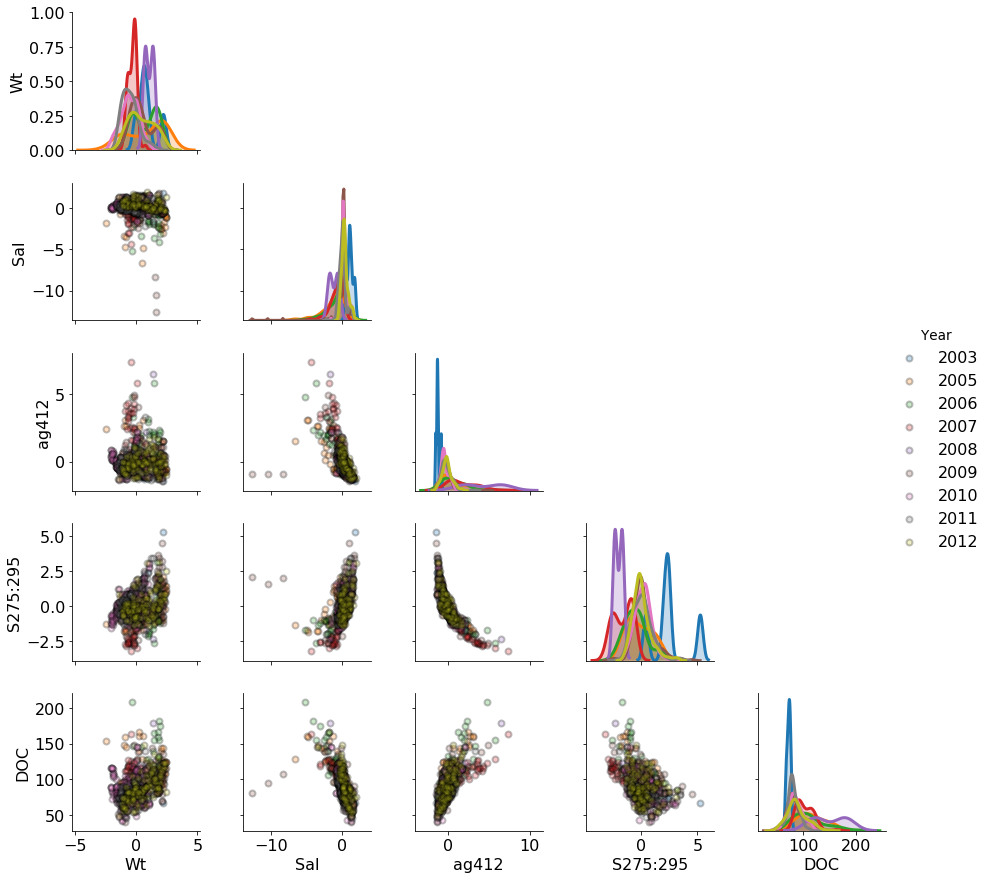

In [261]:
g = PairGrid(pd.concat((x_train_s, y_train), axis=1, ), diag_sharey=False, hue='year',
             vars=[ 'Wt', 'Sal', 'ag412', 'S275:295', 'DOC'])
g.map_diag(kdeplot, lw=3, shade=True)
g.map_lower(pl.scatter, edgecolor='k', linewidth=2, alpha=0.25)
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)
g.add_legend(title='Year');